In [0]:
!pip install Unidecode

     |████████████████████████████████| 245kB 2.8MB/s 


In [0]:
import pandas as pd
import string
import nltk
import numpy as np
import re
import json
import unidecode
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import minmax_scale

In [0]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load dataset from metadata file
file=open("/content/drive/My Drive/ML project'20/YelpZip/metadata")
data=file.readlines()
file.close()
for ind in range(len(data)):
    data[ind]=data[ind].split()

In [0]:
# Load reviews from reviewcontent file
file2=open("/content/drive/My Drive/ML project'20/YelpZip/reviewContent")
text=file2.readlines()
file2.close()
for i in range(len(text)):
    text[i]=text[i].split("\t")
text=[t[3] for t in text]

In [0]:
Dataset=pd.DataFrame(data,columns=["user_id",'product_id','rating','label','date'])
Dataset["review_text"]=text

In [0]:
pd.set_option('mode.chained_assignment', None)

In [0]:
Dataset['rating']=Dataset['rating'].astype('float')
Dataset['date']=pd.to_datetime(Dataset['date'])
Dataset['day']=Dataset['date'].dt.day_name()
Dataset['year']=Dataset.date.dt.year
Dataset['label']=Dataset.label.astype(int)

In [0]:
Y={}
for y in Dataset.year:
  if y in Y:
    Y[y]+=1
  else:
    Y[y]=0
Y

{2004: 2,
 2005: 426,
 2006: 2261,
 2007: 7535,
 2008: 16781,
 2009: 31907,
 2010: 54578,
 2011: 80212,
 2012: 97961,
 2013: 131225,
 2014: 180674,
 2015: 5024}

### **Split Train-Valid-Test Dataset**

In [0]:
x=Dataset[Dataset.year== 2012]
x_real=x[x.label==1]
x_fake=x[x.label==-1]
train_data=x_real.sample(n=12500)
train_data=pd.concat([train_data,x_fake.sample(n=12500)],ignore_index=True)
train_data=train_data.sample(frac=1)

x=Dataset[Dataset.year== 2013]
x_real=x[x.label==1]
x_fake=x[x.label==-1]
val_data=x_real.sample(n=2500)
val_data=pd.concat([val_data,x_fake.sample(n=2500)],ignore_index=True)
val_data=val_data.sample(frac=1)

x=Dataset[Dataset.year== 2014]
test_data=x_real.sample(n=5000)
x_real=x[x.label==1]
x_fake=x[x.label==-1]
test_data=pd.concat([test_data,x_fake.sample(n=5000)],ignore_index=True)
test_data=test_data.sample(frac=1)

In [0]:
train_data

,user_id,product_id,rating,label,date,review_text,day,year
11357,90443,2387,5.0,1,2012-05-26,I have been here twice for breakfast in the pa...,Saturday,2012
4479,93011,1859,5.0,1,2012-10-10,This place is awesome! Food is great and alway...,Wednesday,2012
24433,34794,3866,4.0,-1,2012-06-04,service was fast and friendly. Pizza was decen...,Monday,2012
16268,94638,970,5.0,-1,2012-02-17,This place is great! A cozy and friendly place...,Friday,2012
20069,172323,2776,5.0,-1,2012-06-10,When I first sat down and looked over the menu...,Sunday,2012
...,...,...,...,...,...,...,...,...
15182,103684,1401,5.0,-1,2012-11-19,We were in New York for my daughters 21st birt...,Monday,2012
15379,86555,1690,4.0,-1,2012-02-13,I LOVE this place. There are so many great th...,Monday,2012
12851,59087,1694,4.0,-1,2012-11-12,surprised with some of the reviews... i always...,Monday,2012
19819,229634,4083,5.0,-1,2012-06-20,I love this place. Sometimes simplicity is th...,Wednesday,2012


### **Hand Crafted Features**

In [0]:

#Train Dataset
#Review centric features
train_data['word_count']=train_data['review_text'].apply(lambda x: len(x.split()))
train_data['punctuation_count']=train_data['review_text'].apply(lambda x: len(''.join(c for c in x if c in string.punctuation)))
train_data['char_count']=train_data['review_text'].apply(lambda x: len(x))
train_data['title_count']=train_data['review_text'].apply(lambda x: len([word for word in x.split() if word.istitle()]))
print("-----------review_centric features extracted-------------/")
# user-centric features
train_data['user_id_no_of_review'] = train_data.groupby('user_id')['user_id'].transform('size')
train_data['user_id_ave_rating'] = train_data.groupby('user_id')['rating'].transform('mean')
train_data['user_id_ave_no_words'] = train_data.groupby('user_id')['word_count'].transform('mean')
train_data['user_id_max_review_a_day'] = train_data.groupby(['user_id','day'])['user_id'].transform('size')
print("-----------user_centric features extracted-------------/")
#Product centric feature
train_data['product_id_no_of_review']=train_data.groupby('product_id')['product_id'].transform('size')
train_data['product_id_ave_rating']=train_data.groupby('product_id')['rating'].transform('mean')
train_data['product_id_ave_no_of_words']=train_data.groupby('product_id')['word_count'].transform('mean')
train_data['product_id_max_review_a_day']=train_data.groupby(['product_id','day'])['user_id'].transform('size')
print("-----------product_centric features extracted-------------/\n\n")

#Val dataset
#Review centric features
val_data['word_count']=val_data['review_text'].apply(lambda x: len(x.split()))
val_data['punctuation_count']=val_data['review_text'].apply(lambda x: len(''.join(c for c in x if c in string.punctuation)))
val_data['char_count']=val_data['review_text'].apply(lambda x: len(x))
val_data['title_count']=val_data['review_text'].apply(lambda x: len([word for word in x.split() if word.istitle()]))
print("-----------review_centric features extracted-------------/")
# user-centric features
val_data['user_id_no_of_review'] = val_data.groupby('user_id')['user_id'].transform('size')
val_data['user_id_ave_rating'] = val_data.groupby('user_id')['rating'].transform('mean')
val_data['user_id_ave_no_words'] = val_data.groupby('user_id')['word_count'].transform('mean')
val_data['user_id_max_review_a_day'] = val_data.groupby(['user_id','day'])['user_id'].transform('size')
print("-----------user_centric features extracted-------------/")
#Product centric feature
val_data['product_id_no_of_review']=val_data.groupby('product_id')['product_id'].transform('size')
val_data['product_id_ave_rating']=val_data.groupby('product_id')['rating'].transform('mean')
val_data['product_id_ave_no_of_words']=val_data.groupby('product_id')['word_count'].transform('mean')
val_data['product_id_max_review_a_day']=val_data.groupby(['product_id','day'])['user_id'].transform('size')
print("-----------product_centric features extracted-------------/\n\n")

#Test dataset
test_data['word_count']=test_data['review_text'].apply(lambda x: len(x.split()))
test_data['punctuation_count']=test_data['review_text'].apply(lambda x: len(''.join(c for c in x if c in string.punctuation)))
test_data['char_count']=test_data['review_text'].apply(lambda x: len(x))
test_data['title_count']=test_data['review_text'].apply(lambda x: len([word for word in x.split() if word.istitle()]))
print("-----------review_centric features extracted-------------/")
# user-centric features
test_data['user_id_no_of_review'] = test_data.groupby('user_id')['user_id'].transform('size')
test_data['user_id_ave_rating'] = test_data.groupby('user_id')['rating'].transform('mean')
test_data['user_id_ave_no_words'] = test_data.groupby('user_id')['word_count'].transform('mean')
test_data['user_id_max_review_a_day'] = test_data.groupby(['user_id','day'])['user_id'].transform('size')
print("-----------user_centric features extracted-------------/")
#Product centric feature
test_data['product_id_no_of_review']=test_data.groupby('product_id')['product_id'].transform('size')
test_data['product_id_ave_rating']=test_data.groupby('product_id')['rating'].transform('mean')
test_data['product_id_ave_no_of_words']=test_data.groupby('product_id')['word_count'].transform('mean')
test_data['product_id_max_review_a_day']=test_data.groupby(['product_id','day'])['user_id'].transform('size')
print("-----------product_centric features extracted-------------/")

-----------review_centric features extracted-------------/
-----------user_centric features extracted-------------/
-----------product_centric features extracted-------------/


-----------review_centric features extracted-------------/
-----------user_centric features extracted-------------/
-----------product_centric features extracted-------------/


-----------review_centric features extracted-------------/
-----------user_centric features extracted-------------/
-----------product_centric features extracted-------------/


### **Text Preprocessing**

In [0]:
#Function for expanding all the contractions in the paragraph
with open("/content/drive/My Drive/ML project'20/Contractions.json",'r') as file:
   Contractions=json.load(file)
c_re = re.compile('(%s)' % '|'.join(Contractions.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return Contractions[match.group(0)]
    return c_re.sub(replace, text)

In [0]:
# lowercase,remove digits,punctuations,expand contractions,stopwords and lemmatization
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
train_data['review_text']=train_data['review_text'].apply(lambda x:unidecode.unidecode(x))  #Remove accented characters
train_data['review_text']=train_data['review_text'].apply(lambda x: expandContractions(x))  # expand contractions(eg. I've to I have) 
train_data['review_text']=train_data['review_text'].apply(lambda x:x.lower())   #Convert into lowercase

#Val dataset
val_data['review_text']=val_data['review_text'].apply(lambda x:unidecode.unidecode(x))  #Remove accented characters
val_data['review_text']=val_data['review_text'].apply(lambda x: expandContractions(x))  # expand contractions(eg. I've to I have) 
val_data['review_text']=val_data['review_text'].apply(lambda x:x.lower())   #Convert into lowercase


# Test Dataset
test_data['review_text']=test_data['review_text'].apply(lambda x: unidecode.unidecode(x))
test_data['review_text']=test_data['review_text'].apply(lambda x: expandContractions(x))
test_data['review_text']=test_data['review_text'].apply(lambda x:x.lower())   #Convert into lowercase


### **Data Visualization**

In [0]:
train_data.head()

,user_id,product_id,rating,label,date,review_text,day,year,word_count,punctuation_count,char_count,title_count,user_id_no_of_review,user_id_ave_rating,user_id_ave_no_words,user_id_max_review_a_day,product_id_no_of_review,product_id_ave_rating,product_id_ave_no_of_words,product_id_max_review_a_day
11357,90443,2387,5.0,1,2012-05-26,i have been here twice for breakfast in the pa...,Saturday,2012,44,5,267,2,1,5.0,44.00,1,9,4.111111,88.444444,2
4479,93011,1859,5.0,1,2012-10-10,this place is awesome! food is great and alway...,Wednesday,2012,88,14,503,17,2,4.5,87.50,1,92,3.380435,121.271739,10
24433,34794,3866,4.0,-1,2012-06-04,service was fast and friendly. pizza was decen...,Monday,2012,11,2,70,1,4,4.0,22.25,2,9,3.444444,51.666667,3
16268,94638,970,5.0,-1,2012-02-17,this place is great! a cozy and friendly place...,Friday,2012,45,13,268,3,1,5.0,45.00,1,19,4.105263,100.736842,3
20069,172323,2776,5.0,-1,2012-06-10,when i first sat down and looked over the menu...,Sunday,2012,101,14,545,11,2,5.0,85.50,2,36,3.916667,132.166667,8


In [0]:
day_of_week_real= train_data[train_data.label==1].groupby('day')
day_of_week_fake= train_data[train_data.label==-1].groupby('day')
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
count_r=np.zeros(7)
count_f=np.zeros(7)
for day in day_of_week_real:
  count_r[days.index(day[0])]=(day[1].shape[0])
for day in day_of_week_fake:
  count_f[days.index(day[0])]=(day[1].shape[0])

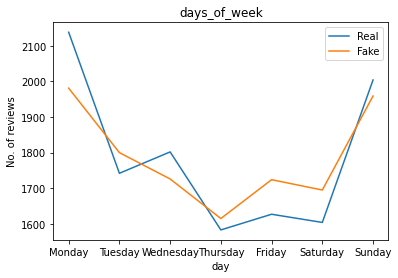

In [0]:
plt.plot(days,count_r,label='Real')
plt.plot(days,count_f,label='Fake')
plt.legend(loc='upper left')
plt.xlabel('day')
plt.ylabel('No. of reviews')
plt.title('days_of_week')
plt.legend()
plt.show()

In [0]:
real_rating=train_data[train_data.label==1].groupby('rating')
fake_rating=train_data[train_data.label==-1].groupby('rating')
rating=[r[0] for r in real_rating]
rating_r=[r[1].shape[0]/12500 for r in real_rating]
rating_f=[r[1].shape[0]/12500 for r in fake_rating]

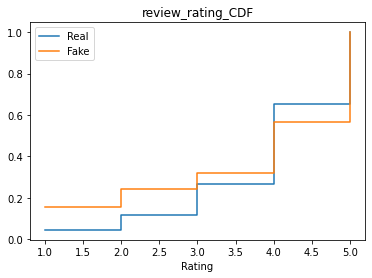

In [0]:
plt.step(rating,np.cumsum(rating_r),label='Real',where='post')
plt.step(rating,np.cumsum(rating_f),label='Fake',where='post')
plt.legend(loc='upper left')
plt.xlabel('Rating')
plt.title('review_rating_CDF')
plt.legend()
plt.show()

In [0]:
real_rating=train_data[train_data.label==1].groupby('word_count')
fake_rating=train_data[train_data.label==-1].groupby('word_count')
# rating=[r[0] for r in real_rating]
count_r=[w[0] for w in real_rating]
count_f=[w[0] for w in fake_rating]
word_count_r=[w[1].shape[0]/12500 for w in real_rating]
word_count_f=[w[1].shape[0]/12500 for w in fake_rating]

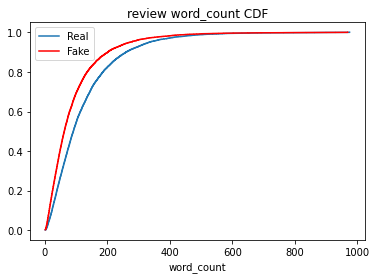

In [0]:
plt.step(count_r,np.cumsum(word_count_r),label='Real',where='post')
plt.step(count_f,np.cumsum(word_count_f),color='red',label='Fake',where='post')
plt.legend(loc='lower left')
plt.xlabel('word_count')
plt.title('review word_count CDF')
plt.legend()
plt.show()

In [0]:
real_rating=train_data[train_data.label==1].groupby('user_id_max_review_a_day')
fake_rating=train_data[train_data.label==-1].groupby('user_id_max_review_a_day')
# rating=[r[0] for r in real_rating]
count_r=[w[0] for w in real_rating]
count_f=[w[0] for w in fake_rating]
word_count_r=[w[1].shape[0]/12500 for w in real_rating]
word_count_f=[w[1].shape[0]/12500 for w in fake_rating]

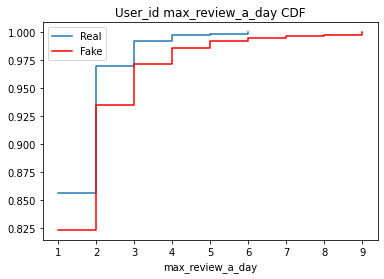

In [0]:
plt.step(count_r,np.cumsum(word_count_r),label='Real',where='post')
plt.step(count_f,np.cumsum(word_count_f),color='red',label='Fake',where='post')
plt.legend(loc='lower left')
plt.xlabel('max_review_a_day')
plt.title('User_id max_review_a_day CDF')
plt.legend()
plt.show()

#### **Save Train, Valid and test csv file**

In [0]:
train_data.to_csv("/content/drive/My Drive/ML project'20/YelpZip/train_newb.csv",index=False)
val_data.to_csv("/content/drive/My Drive/ML project'20/YelpZip/val_newb.csv",index=False)
test_data.to_csv("/content/drive/My Drive/ML project'20/YelpZip/test_newb.csv",index=False)